In [1]:
CUDA_INDEX = 1
NAME = 'DBLP'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [4]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}-FS2/inner_pred.pt', map_location='cpu')),
    ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}-FS2/nn_inner_pred.pt', map_location='cpu')),
    ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}-FS2/dual_inner_pred.pt', map_location='cpu')),
#     ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}-FS2/sg_inner_pred.npy'))),
#     ('Branch        ', torch.load(f'../preds/{NAME}-FS2/b_inner_pred.pt', map_location='cpu')),
#     ('F2            ', torch.load(f'../preds/{NAME}-FS2/f2_inner_pred.pt', map_location='cpu')),
]

In [5]:
inner_test_set, _ = torch.load(f'/data/rishabh/neurosim/final/data/{NAME}/inner_test.pt', map_location='cpu')
queries, _, lb, ub = inner_test_set
sed = (lb+ub)/2

In [7]:
def f(x):
    if(x>50):
        return 0
    elif x<-50:
        return 0
    else:
        return x

In [8]:
print('=== RMSE / MAE / R2 ===')
print()
for label, pred in preds:
#     print(f'{label}', end='\n')
    pred = torch.Tensor(list(map(f,pred)))
    print(f'{metrics.rmse(lb, ub, pred):.3f}', end=' / ')
    print(f'{metrics.mae(lb, ub, pred):.3f}', end=' / ')
    print(f'{metrics.r2(lb, ub, pred)*100:.2f}')
#     print()

=== RMSE / MAE / R2 ===

2.836 / 1.665 / 76.65
2.982 / 1.712 / 74.19
4.530 / 2.793 / 40.46


In [22]:
## remove outliers predictions

def valid(pred):
    return (pred<50) & (pred>-50)
    

print('=== RMSE / MAE / R2 ===')
print()
for label, pred in preds:
#     print(f'{label}', end='\n')
    val = valid(pred)
    print(lb[~val])
    print(ub[~val])
    print(pred[~val])
    print()
    pred,lb_,ub_ = pred[val],lb[val],ub[val]
    print(f'{metrics.rmse(lb_, ub_, pred):.3f}', end=' / ')
    print(f'{metrics.mae(lb_, ub_, pred):.3f}', end=' / ')
    print(f'{metrics.r2(lb_, ub_, pred)*100:.2f}')
#     print()

=== RMSE / MAE / R2 ===

tensor([0., 4.])
tensor([0., 4.])
tensor([17950.3945,   454.9814])

2.851 / 1.679 / 76.41
tensor([])
tensor([])
tensor([])

2.982 / 1.712 / 74.19
tensor([0.])
tensor([42.])
tensor([122.9206])

4.530 / 2.793 / 40.46


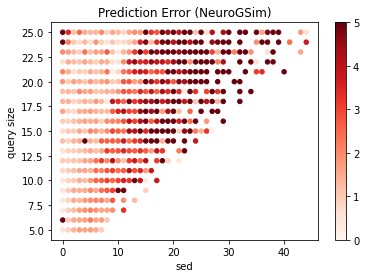

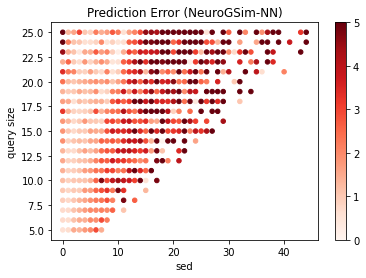

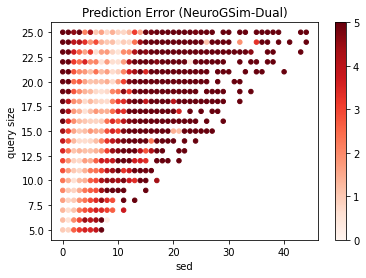

In [7]:
for label, pred in preds:
    err = metrics.err(lb, ub, pred)
    plt.figure()
    gsz = torch.tensor([g.num_nodes for g in queries])
    viz.plot_corr_2d(sed, gsz, err, xmax1=50, xmax2=25, bin_size1=1, bin_size2=1, s=20, cmap='Reds', vmax=5, vmin=0)
    plt.colorbar()
    plt.xlabel('sed')
    plt.ylabel('query size')
    plt.title(f'Prediction Error ({label.strip()})')
    plt.show()